# **Parkinson's Disease Progression Prediction**

The goal is to predict MDS-UPDR scores, which measure progression in patients with Parkinson's disease. The Movement Disorder Society-Sponsored Revision of the Unified Parkinson's Disease Rating Scale (MDS-UPDRS) is a comprehensive assessment of both motor and non-motor symptoms associated with Parkinson's. We will develop a model trained on data of protein and peptide levels over time in subjects with Parkinson’s disease versus normal age-matched control subjects.

# **EDA and Pre-processing**

## **Datasets reading and overview**

In [1]:
# import some libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
# read csv files
df_peptides = pd.read_csv("train_peptides.csv")
df_proteins = pd.read_csv("train_proteins.csv")
df_clinical_data = pd.read_csv("train_clinical_data.csv")

In [3]:
# Show the number of rows and columns
print('Peptides dataframe has # Rows: %s, # Columns: %s' % (df_peptides.shape[0],df_peptides.shape[1]))
print('Proteins dataframe has # Rows: %s, # Columns: %s' % (df_proteins.shape[0],df_proteins.shape[1]))
print('Clinical dataframe has # Rows: %s, # Columns: %s' % (df_clinical_data.shape[0],df_clinical_data.shape[1]))

Peptides dataframe has # Rows: 981834, # Columns: 6
Proteins dataframe has # Rows: 232741, # Columns: 5
Clinical dataframe has # Rows: 2615, # Columns: 8


In [4]:
# Check the types of variables
df_peptides.info()
print('\n')
df_proteins.info()
print('\n')
df_clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  object 
 5   PeptideAbundance  981834 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 44.9+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232741 entries, 0 to 232740
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   visit_id     232741 non-null  object 
 1   visit_month  232741 non-null  int64  
 2   patient_id   232741 non-null  int64  
 3   UniProt      232741 non-null  object 
 4   NPX          232741 non-null  float64
dtypes: float64(1), int64(2), 

##**Peptides dataframe**

### Peptides dataframe EDA

In [5]:
# Dataframe visualization
df_peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [6]:
# Look NaNs
df_peptides.isnull().sum()

visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
dtype: int64

In [7]:
# Check 'UniProt' column distribution
df_peptides['UniProt'].value_counts()

P02787    51916
P02768    40900
P01024    35253
P02751    27370
P02649    23082
          ...  
Q6UX71      661
P01780      654
Q562R1      616
Q99832      606
Q99829      489
Name: UniProt, Length: 227, dtype: int64

In [8]:
# Review some statistics from the 'PeptideAbundance' column
df_peptides['PeptideAbundance'].describe()

count    9.818340e+05
mean     6.428902e+05
std      3.377989e+06
min      1.099850e+01
25%      2.817425e+04
50%      7.430830e+04
75%      2.213388e+05
max      1.787520e+08
Name: PeptideAbundance, dtype: float64

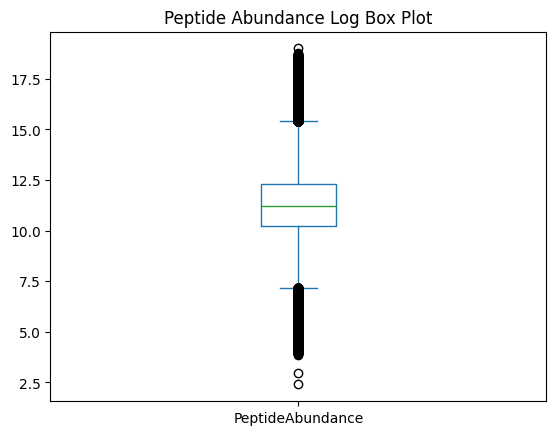

In [9]:
# Plot a boxplot of 'PeptideAbundance' column
np.log(df_peptides['PeptideAbundance']).plot(kind="box")
plt.title('Peptide Abundance Log Box Plot')
plt.show()

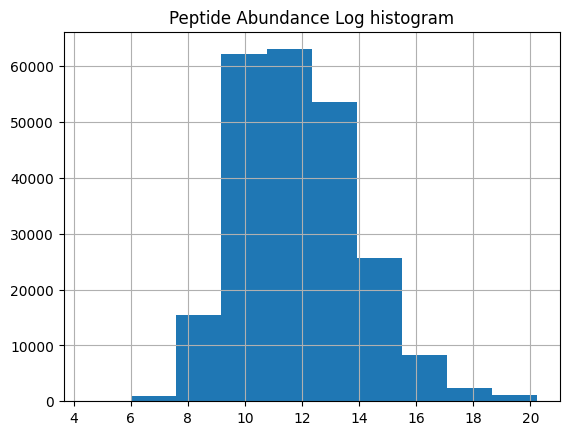

In [10]:
np.log(df_proteins['NPX']).hist()
plt.title('Peptide Abundance Log histogram')
plt.show()

### Peptides dataframe Pre-processing (Cleaning)

**Identify post-translational modifications in peptides (UniMod signatures)**

Such post-translational changes are indicated as (UniMod_{x}) in the peptide string of column Peptide. We search for these patterns in all peptide sequences.

In [11]:
# Show the number of post-translational modifications
print('There are {} post-translational modifications'.format(df_peptides['Peptide'].str.contains('UniMod_').value_counts()[True]))

There are 328689 post-translational modifications


In [12]:
# Define a function to extract UniMods from peptides
import re
def extract_UniMods(peptide):
    return re.findall(r'[A-Z]\(UniMod_\d+\)', peptide)

In [13]:
# Copy df_peptides dataframe in a new dataframe
df_peptides_UniMods = df_peptides.copy()

In [14]:
# Define 'Peptide' column as string type
df_peptides_UniMods['Peptide'] = df_peptides_UniMods['Peptide'].apply(str)

# Apply the function to 'Peptide' column and create 'UniMods' column
df_peptides_UniMods['UniMods'] = df_peptides_UniMods['Peptide'].apply(extract_UniMods)

# Count the number of UniMods for each peptide
df_peptides_UniMods['UniMods.n'] = df_peptides_UniMods['UniMods'].apply(len)

# Remove duplicate UniMods within each peptide
df_peptides_UniMods['UniMods_no_duplicates'] = df_peptides_UniMods['UniMods'].apply(lambda x: list(set(x)))

# Explode 'UniMods' column, keeping empty lists
peptides = df_peptides_UniMods.explode('UniMods_no_duplicates')

# Count the occurrence of each UniMod
counts = peptides['UniMods_no_duplicates'].value_counts().reset_index()

# Rename columns
counts.columns = ['UniMods', 'counts']

print(counts)

        UniMods  counts
0   C(UniMod_4)  309587
1  M(UniMod_35)   28753


There are only two post-translational modifications with accession #4 and #35 in the UniMod database.

Since all (UniMod_4) and (UniMod_35) modifications are due to sample preparation, we remove them.

In [15]:
# Remove (UniMod_4) and (UniMod_35) modifications
df_peptides['Peptide_cleaned'] = df_peptides['Peptide'].replace(['\(UniMod_35\)','\(UniMod_4\)'],'', regex=True)
df_peptides.iloc[100:105,:]

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,Peptide_cleaned
100,55_0,0,55,P01009,KQINDYVEKGTQGK,34955.9,KQINDYVEKGTQGK
101,55_0,0,55,P01009,LGMFNIQHC(UniMod_4)K,1476020.0,LGMFNIQHCK
102,55_0,0,55,P01009,LSITGTYDLK,3212810.0,LSITGTYDLK
103,55_0,0,55,P01009,LSSWVLLM(UniMod_35)K,80227.9,LSSWVLLMK
104,55_0,0,55,P01009,LSSWVLLMK,917115.0,LSSWVLLMK


## **Proteins dataframe**

### Proteins  dataframe EDA

In [16]:
# Dataframe visualization
df_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [17]:
# Look NaNs
df_proteins.isnull().sum()

visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
dtype: int64

In [18]:
# Check 'UniProt' column distribution
df_proteins['UniProt'].value_counts()

P01024    1113
P05090    1113
P01011    1113
P01023    1113
Q92520    1113
          ... 
Q6UX71     661
P01780     654
Q562R1     616
Q99832     606
Q99829     489
Name: UniProt, Length: 227, dtype: int64

In [19]:
# Review some statistics from the 'NPX' column
df_proteins['NPX'].describe()

count    2.327410e+05
mean     2.712077e+06
std      2.224155e+07
min      8.460820e+01
25%      2.946440e+04
50%      1.135560e+05
75%      5.638940e+05
max      6.138510e+08
Name: NPX, dtype: float64

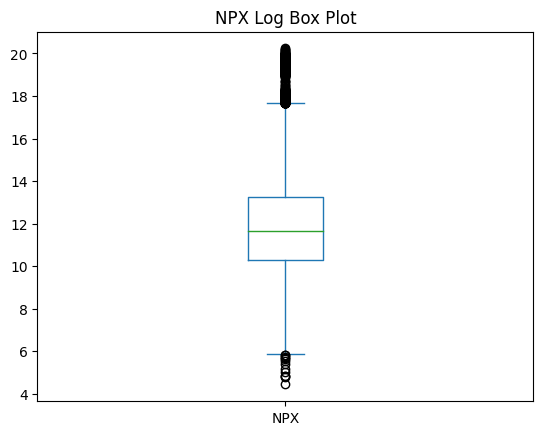

In [20]:
# Plot a boxplot of 'NPX' column
np.log(df_proteins['NPX']).plot(kind="box")
plt.title('NPX Log Box Plot')
plt.show()

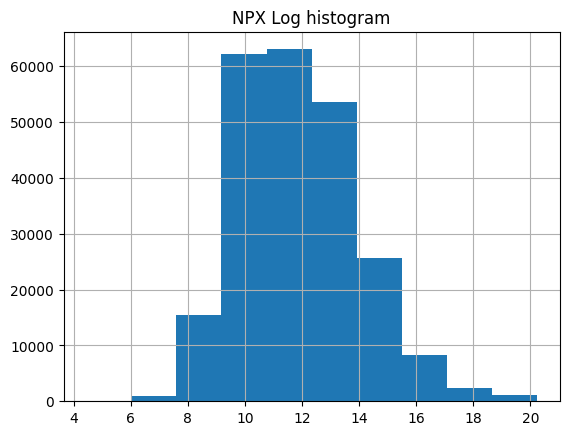

In [21]:
np.log(df_proteins['NPX']).hist()
plt.title('NPX Log histogram')
plt.show()

### Proteins dataframe Pre-processing and Feature engineering

In [22]:
# Import OneHotEncoder library
from sklearn.preprocessing import OneHotEncoder

In [23]:
# Make the one hot encode
ohe = OneHotEncoder()
uniprot_encode = ohe.fit_transform(np.expand_dims(df_proteins['UniProt'], axis=1)).toarray()
uniprot_encode.shape

(232741, 227)

In [24]:
# Change dataframe 'NPX' column into numpy
proteins_NPX = df_proteins['NPX'].to_numpy()
proteins_NPX = np.expand_dims(proteins_NPX, axis=1)
proteins_NPX.shape

(232741, 1)

In [25]:
# Apply log transformation
proteins_logNPX = np.log(proteins_NPX)
proteins_logNPX.shape

(232741, 1)

In [26]:
# Multiply one hot encode matrix by log 'NPX' column vector
proteins_encode_logNPX = uniprot_encode * proteins_logNPX
proteins_encode_logNPX.shape

(232741, 227)

In [27]:
print(proteins_encode_logNPX)

[[ 9.32850556  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         13.50412305  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         10.58622575 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          9.96446976
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   9.79551808]]


In [28]:
# Define the encoded data columns names
names = ohe.get_feature_names_out()
column_names = [name[name.find("_")+1:] for name in names]

In [29]:
# New proteins dataframe generation with encode data
df_proteins_encode_logNPX = pd.DataFrame(proteins_encode_logNPX, columns=column_names)
df_proteins_processed = pd.concat([df_proteins['visit_id'], df_proteins_encode_logNPX], axis=1)
df_proteins_processed.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,55_0,9.328506,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55_0,0.000000,13.504123,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,55_0,0.000000,0.000000,10.586226,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55_0,0.000000,0.000000,0.000000,10.634097,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55_0,0.000000,0.000000,0.000000,0.000000,10.349391,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Group new proteins dataframes rows by 'visit_id' in order to merge protein information
df_proteins_processed_ = df_proteins_processed.groupby('visit_id', as_index=False, sort=False).sum()
df_proteins_processed_.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,55_0,9.328506,13.504123,10.586226,10.634097,10.349391,8.343485,12.088274,11.049273,12.717026,...,12.808953,10.478076,11.482524,10.048561,11.017195,12.920732,0.000000,10.300880,10.078856,9.849744
1,1517_0,9.362967,12.945662,10.464639,0.000000,9.768029,7.931788,11.684793,10.603484,12.021681,...,12.632255,10.123879,0.000000,9.442317,10.597107,12.012646,10.921970,10.359741,9.892002,9.595569
2,1923_0,9.969360,13.672777,10.374587,0.000000,9.501001,0.000000,12.502861,11.309342,12.662674,...,11.064131,10.984296,11.665518,9.549758,11.108752,13.121631,11.071351,10.149910,10.179079,10.068879
3,2660_0,0.000000,13.270489,10.249196,10.305052,9.859227,7.541476,11.808643,11.165703,12.270431,...,12.323451,10.380473,11.756099,9.557371,10.180627,12.591855,10.915946,9.791466,10.151519,9.797621
4,3636_0,9.295325,12.496508,9.340526,9.661180,8.801795,7.993907,11.027691,10.163071,11.193212,...,12.356138,0.000000,11.189873,8.955786,9.721852,11.861848,0.000000,0.000000,8.985329,9.058006


In [31]:
# Import RobustScaler library
from sklearn.preprocessing import RobustScaler

In [32]:
# Scale proteins processed dataframe
scaler = RobustScaler()
scaler.fit(df_proteins_processed_.iloc[:,1:])
proteins_scaled = scaler.transform(df_proteins_processed_.iloc[:,1:])
df_proteins_scaled = pd.DataFrame(proteins_scaled, columns=df_proteins_processed_.iloc[:,1:].columns)

In [33]:
# New proteins dataframe generation with scaled data
df_proteins_ = pd.concat([df_proteins_processed_['visit_id'], df_proteins_scaled], axis=1)
df_proteins_.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,55_0,0.013127,0.670496,0.763220,0.980540,1.045347,0.723823,0.493669,0.411514,1.117953,...,0.461159,0.076783,-0.231475,0.911468,1.140102,1.095780,-14.428781,0.065964,0.540623,0.066043
1,1517_0,0.016781,-0.230696,0.533761,-20.642740,0.058720,0.099265,0.018511,-0.314723,-0.208763,...,0.250633,-0.334073,-30.470617,-0.225343,0.278439,-0.442750,-0.142632,0.071873,0.094211,-0.281903
2,1923_0,0.081074,0.942653,0.363814,-20.642740,-0.394453,-11.933514,0.981905,0.835193,1.014250,...,-1.617695,0.663979,0.250438,-0.023872,1.327897,1.436155,0.052761,0.050811,0.780066,0.366023
3,2660_0,-0.975931,0.293478,0.127174,0.311463,0.213493,-0.492851,0.164362,0.601191,0.265852,...,-0.117288,-0.036434,0.488983,-0.009597,-0.575823,0.538580,-0.150511,0.014832,0.714222,-0.005308
4,3636_0,0.009609,-0.955498,-1.587675,-0.997780,-1.581073,0.193502,-0.755321,-1.032201,-1.789479,...,-0.078344,-12.077402,-1.002169,-1.137671,-1.516837,-0.698239,-14.428781,-0.967985,-2.071915,-1.017786


## **Clinical_data dataframe**

### Clinical_data dataframe EDA

UPDRS: Unified Parkinson's Disease Rating Scale (higher number = more severe disease)

In [34]:
# Dataframe visualization
df_clinical_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [35]:
# Look NaNs
df_clinical_data.isnull().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

In [36]:
# 'patient_id' distribution and number of patients
df_clinical_data['patient_id'].value_counts()

55096    17
57108    17
15009    17
16778    16
52266    16
         ..
13968     5
20792     5
62732     4
60443     3
14450     3
Name: patient_id, Length: 248, dtype: int64

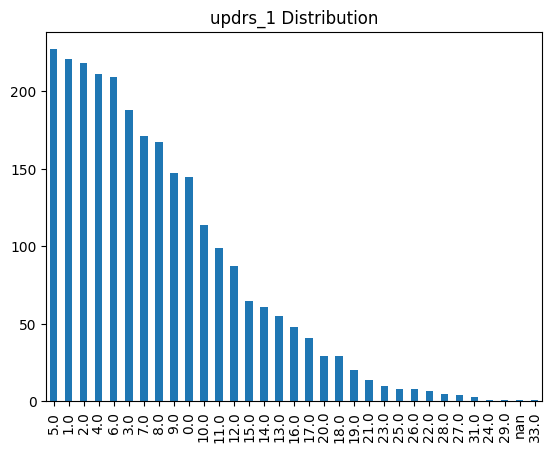

In [37]:
# Plot 'updrs_1' distribution
df_clinical_data['updrs_1'].value_counts(dropna=False).plot(kind='bar')
plt.title('updrs_1 Distribution')
plt.show()

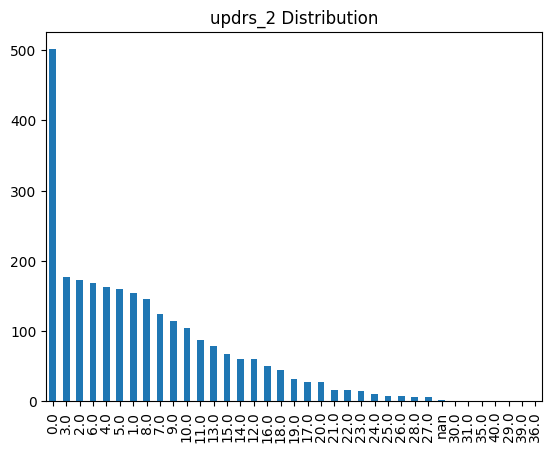

In [38]:
# Plot 'updrs_2' distribution
df_clinical_data['updrs_2'].value_counts(dropna=False).plot(kind='bar')
plt.title('updrs_2 Distribution')
plt.show()

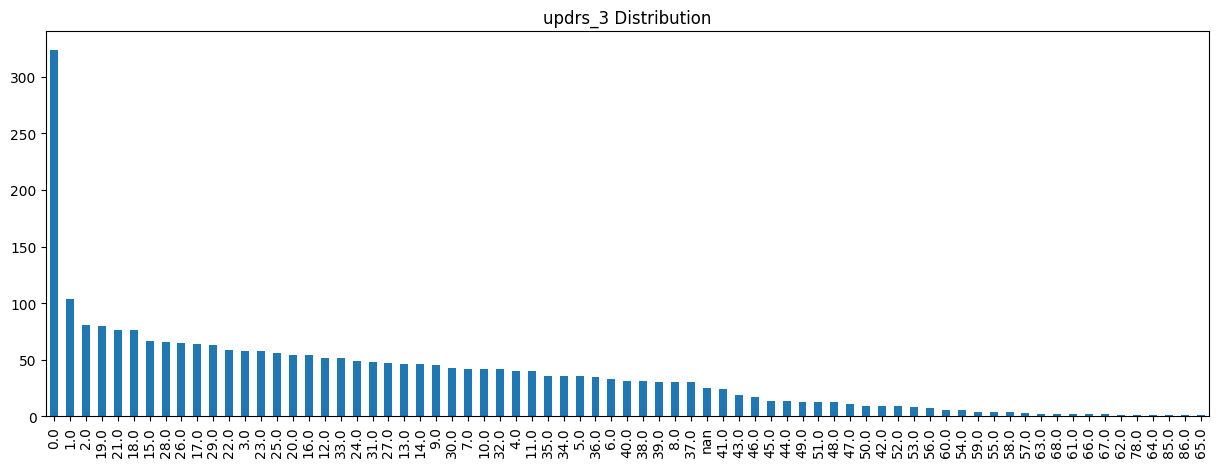

In [39]:
# Plot 'updrs_3' distribution
df_clinical_data['updrs_3'].value_counts(dropna=False).plot(kind='bar', figsize=(15,5))
plt.title('updrs_3 Distribution')
plt.show()

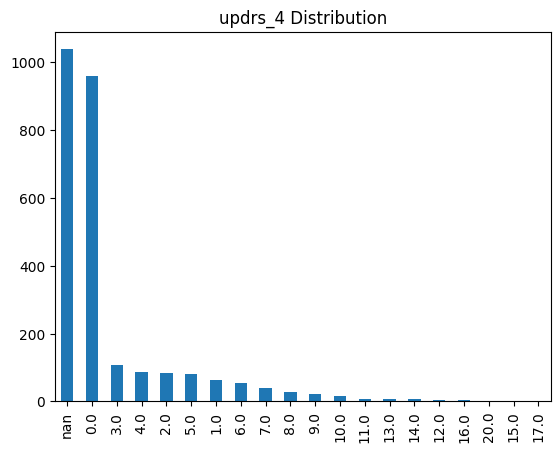

In [40]:
# Plot 'updrs_4' distribution
df_clinical_data['updrs_4'].value_counts(dropna=False).plot(kind='bar')
plt.title('updrs_4 Distribution')
plt.show()

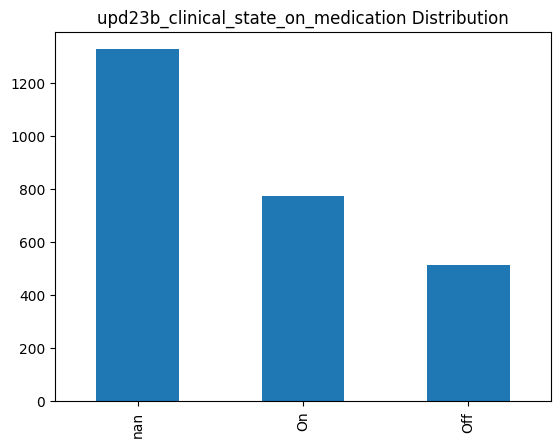

In [41]:
# Plot 'upd23b_clinical_state_on_medication' distribution
df_clinical_data['upd23b_clinical_state_on_medication'].value_counts(dropna=False).plot(kind='bar')
plt.title('upd23b_clinical_state_on_medication Distribution')
plt.show()

### Clinical_data dataframe Feature engineering

We will work with two target columns. The first target will be a subset of the MDS-UPDRS scale, which we will call 'updrs_non_motor', and consists of adding parts 1 and 2 of the dataset, which correspond to the non-motor analysis of the MDS-UPDRS scale. The second target will be the total UPDRS scale, which is achieved by adding all the parts of the updrs scale in the database, and we will call this 'updrs'.

In [42]:
# Create new UPDRS NO MOTOR and UPDRS TOTAL columns
df_clinical_data_ = df_clinical_data.copy()
df_clinical_data_['updrs_non_motor'] = df_clinical_data['updrs_1'] + df_clinical_data['updrs_2']
df_clinical_data_['updrs'] = df_clinical_data['updrs_1'] + df_clinical_data['updrs_2'] + df_clinical_data['updrs_3'] + df_clinical_data['updrs_4']
df_clinical_data_.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_non_motor,updrs
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,16.0,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,17.0,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,18.0,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On,17.0,47.0
4,55_12,55,12,10.0,10.0,41.0,0.0,On,20.0,61.0


In [43]:
# Transform updrs columns into 'Int64' (Integers)
df_clinical_data_['updrs_non_motor'] = df_clinical_data_['updrs_non_motor'].astype('Int64')
df_clinical_data_['updrs'] = df_clinical_data_['updrs'].astype('Int64')
df_clinical_data_['updrs_1'] = df_clinical_data_['updrs_1'].astype('Int64')
df_clinical_data_['updrs_2'] = df_clinical_data_['updrs_2'].astype('Int64')
df_clinical_data_['updrs_3'] = df_clinical_data_['updrs_3'].astype('Int64')
df_clinical_data_['updrs_4'] = df_clinical_data_['updrs_4'].astype('Int64')

In [44]:
# New clinical data generation with some features
df_clinical_data_ = df_clinical_data_.drop(['visit_month', 'patient_id'], axis=1)
df_clinical_data_.head()

,visit_id,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_non_motor,updrs
0,55_0,10,6,15,<NA>,NaN,16,<NA>
1,55_3,10,7,25,<NA>,NaN,17,<NA>
2,55_6,8,10,34,<NA>,NaN,18,<NA>
3,55_9,8,9,30,0,On,17,47
4,55_12,10,10,41,0,On,20,61


# **Training dataframe generation and Pre-processing**

### Training dataframe generation

In [45]:
# Merge protein processed and clinical data processed dataframes by 'visit_id'
df = df_proteins_.merge(df_clinical_data_, left_on='visit_id', right_on='visit_id')
df = df.drop(['visit_id', 'upd23b_clinical_state_on_medication'], axis=1)
df.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs_1,updrs_2,updrs_3,updrs_4,updrs_non_motor,updrs
0,0.013127,0.670496,0.763220,0.980540,1.045347,0.723823,0.493669,0.411514,1.117953,0.392114,...,-14.428781,0.065964,0.540623,0.066043,10,6,15,<NA>,16,<NA>
1,0.016781,-0.230696,0.533761,-20.642740,0.058720,0.099265,0.018511,-0.314723,-0.208763,-0.637695,...,-0.142632,0.071873,0.094211,-0.281903,11,6,25,5,17,47
2,0.081074,0.942653,0.363814,-20.642740,-0.394453,-11.933514,0.981905,0.835193,1.014250,1.429801,...,0.052761,0.050811,0.780066,0.366023,2,0,0,<NA>,2,<NA>
3,-0.975931,0.293478,0.127174,0.311463,0.213493,-0.492851,0.164362,0.601191,0.265852,0.966835,...,-0.150511,0.014832,0.714222,-0.005308,2,0,0,<NA>,2,<NA>
4,0.009609,-0.955498,-1.587675,-0.997780,-1.581073,0.193502,-0.755321,-1.032201,-1.789479,-0.344913,...,-14.428781,-0.967985,-2.071915,-1.017786,1,2,9,<NA>,3,<NA>


<Axes: >

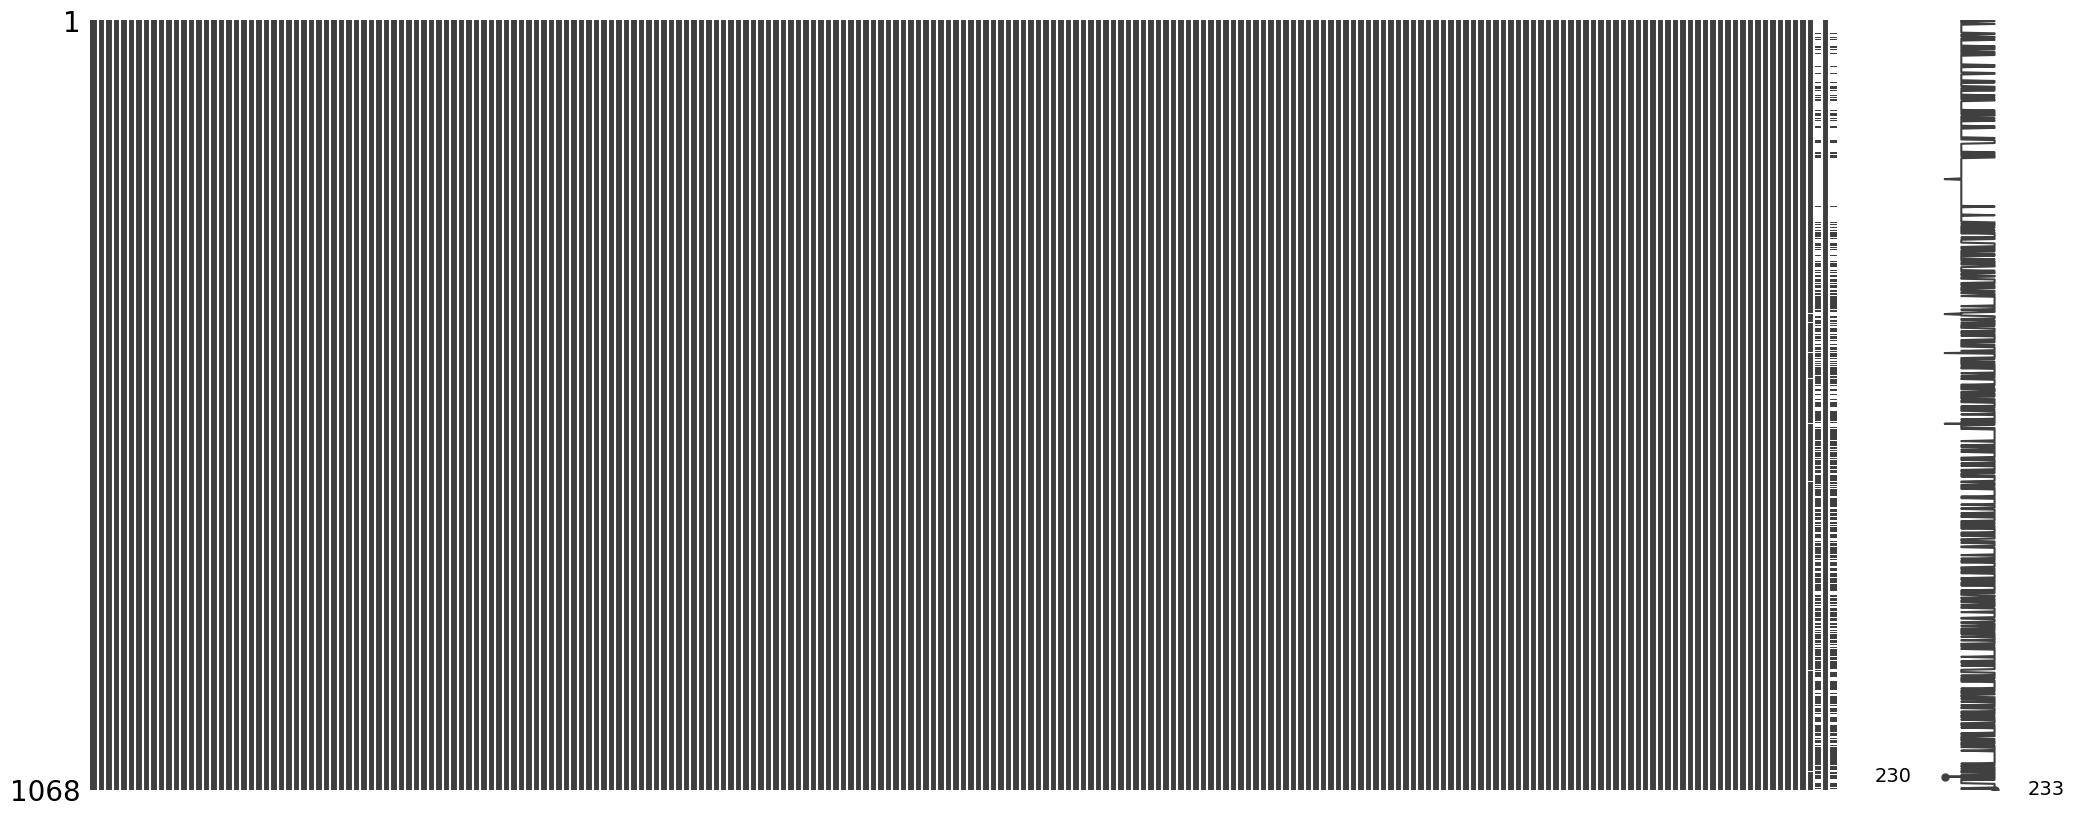

In [46]:
# Plot NaN
msno.matrix(df)

In [47]:
# Count NaN
df.isnull().sum()

O00391               0
O00533               0
O00584               0
O14498               0
O14773               0
                  ... 
updrs_2              0
updrs_3             10
updrs_4            499
updrs_non_motor      0
updrs              504
Length: 233, dtype: int64

### Training dataframe imputation

Columns 'updrs_3', 'updrs_4' and 'updrs' will be imputed by KNN imputation method

In [48]:
# Import KNNImputer
from sklearn.impute import KNNImputer

In [49]:
# Impute dataframe
imputer = KNNImputer()
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns)
df_imputed.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs_1,updrs_2,updrs_3,updrs_4,updrs_non_motor,updrs
0,0.013127,0.670496,0.763220,0.980540,1.045347,0.723823,0.493669,0.411514,1.117953,0.392114,...,-14.428781,0.065964,0.540623,0.066043,10.0,6.0,15.0,1.2,16.0,28.6
1,0.016781,-0.230696,0.533761,-20.642740,0.058720,0.099265,0.018511,-0.314723,-0.208763,-0.637695,...,-0.142632,0.071873,0.094211,-0.281903,11.0,6.0,25.0,5.0,17.0,47.0
2,0.081074,0.942653,0.363814,-20.642740,-0.394453,-11.933514,0.981905,0.835193,1.014250,1.429801,...,0.052761,0.050811,0.780066,0.366023,2.0,0.0,0.0,0.2,2.0,17.2
3,-0.975931,0.293478,0.127174,0.311463,0.213493,-0.492851,0.164362,0.601191,0.265852,0.966835,...,-0.150511,0.014832,0.714222,-0.005308,2.0,0.0,0.0,1.6,2.0,7.6
4,0.009609,-0.955498,-1.587675,-0.997780,-1.581073,0.193502,-0.755321,-1.032201,-1.789479,-0.344913,...,-14.428781,-0.967985,-2.071915,-1.017786,1.0,2.0,9.0,0.6,3.0,22.6


## **First option NPX vs UPDRS**

### First dataframe generation

In [50]:
# Drop unnecessary columns
df1_outliers = df_imputed.drop(['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'updrs_non_motor'], axis=1)
df1_outliers.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs
0,0.013127,0.670496,0.763220,0.980540,1.045347,0.723823,0.493669,0.411514,1.117953,0.392114,...,0.076783,-0.231475,0.911468,1.140102,1.095780,-14.428781,0.065964,0.540623,0.066043,28.6
1,0.016781,-0.230696,0.533761,-20.642740,0.058720,0.099265,0.018511,-0.314723,-0.208763,-0.637695,...,-0.334073,-30.470617,-0.225343,0.278439,-0.442750,-0.142632,0.071873,0.094211,-0.281903,47.0
2,0.081074,0.942653,0.363814,-20.642740,-0.394453,-11.933514,0.981905,0.835193,1.014250,1.429801,...,0.663979,0.250438,-0.023872,1.327897,1.436155,0.052761,0.050811,0.780066,0.366023,17.2
3,-0.975931,0.293478,0.127174,0.311463,0.213493,-0.492851,0.164362,0.601191,0.265852,0.966835,...,-0.036434,0.488983,-0.009597,-0.575823,0.538580,-0.150511,0.014832,0.714222,-0.005308,7.6
4,0.009609,-0.955498,-1.587675,-0.997780,-1.581073,0.193502,-0.755321,-1.032201,-1.789479,-0.344913,...,-12.077402,-1.002169,-1.137671,-1.516837,-0.698239,-14.428781,-0.967985,-2.071915,-1.017786,22.6


### Detecting and treating Outliers

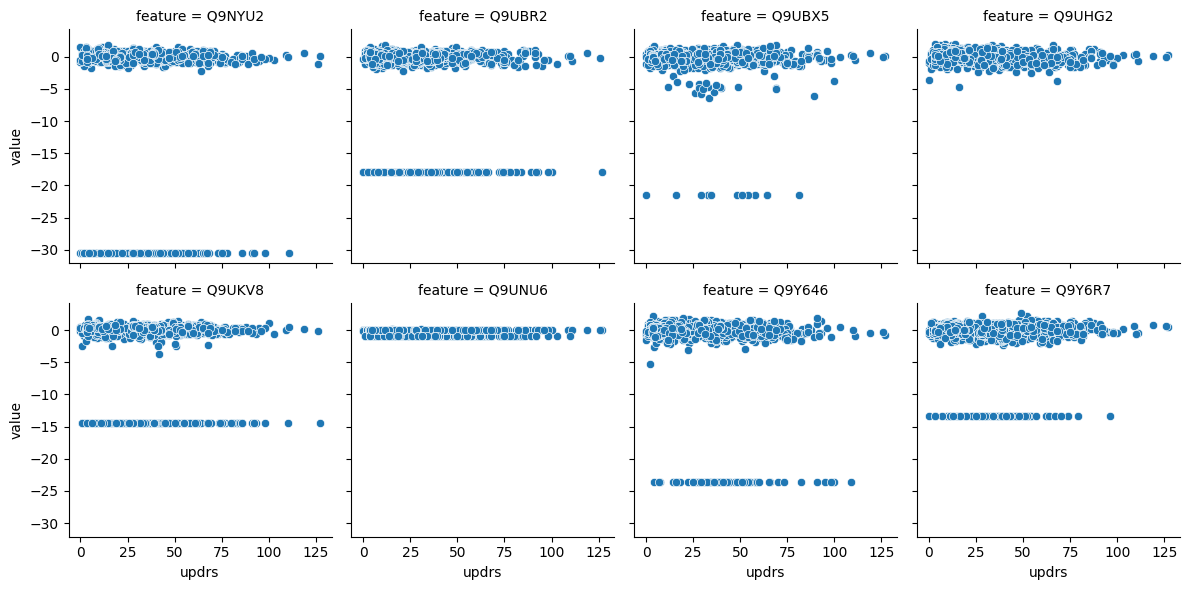

In [51]:
# Plot features (proteins) vs UPDRS
m = df1_outliers.iloc[:,-9:].melt(id_vars=['updrs'], var_name='feature')
g = sns.FacetGrid(m, col='feature', col_wrap=4)
g.map_dataframe(sns.scatterplot, x='updrs', y='value')

<Axes: >

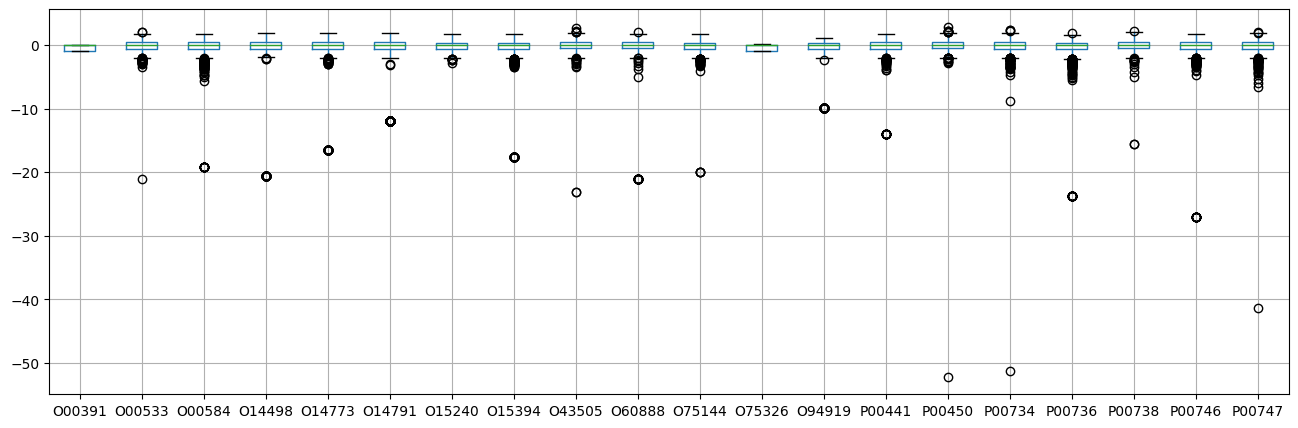

In [52]:
# Plot a boxplot of proteins
df1_outliers.iloc[:,:20].boxplot(figsize=(16,5))

In [53]:
# Impute outliers with the mean
df1 = df1_outliers.mask(df1_outliers < -2, df1_outliers.median(), axis=1)
df1.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs
0,0.013127,0.670496,0.763220,0.980540,1.045347,0.723823,0.493669,0.411514,1.117953,0.392114,...,0.076783,-0.231475,0.911468,1.140102,1.095780,-0.000278,0.065964,0.540623,0.066043,28.6
1,0.016781,-0.230696,0.533761,-0.001925,0.058720,0.099265,0.018511,-0.314723,-0.208763,-0.637695,...,-0.334073,-0.005700,-0.225343,0.278439,-0.442750,-0.142632,0.071873,0.094211,-0.281903,47.0
2,0.081074,0.942653,0.363814,-0.001925,-0.394453,0.000186,0.981905,0.835193,1.014250,1.429801,...,0.663979,0.250438,-0.023872,1.327897,1.436155,0.052761,0.050811,0.780066,0.366023,17.2
3,-0.975931,0.293478,0.127174,0.311463,0.213493,-0.492851,0.164362,0.601191,0.265852,0.966835,...,-0.036434,0.488983,-0.009597,-0.575823,0.538580,-0.150511,0.014832,0.714222,-0.005308,7.6
4,0.009609,-0.955498,-1.587675,-0.997780,-1.581073,0.193502,-0.755321,-1.032201,-1.789479,-0.344913,...,-0.003852,-1.002169,-1.137671,-1.516837,-0.698239,-0.000278,-0.967985,-0.002969,-1.017786,22.6


<Axes: >

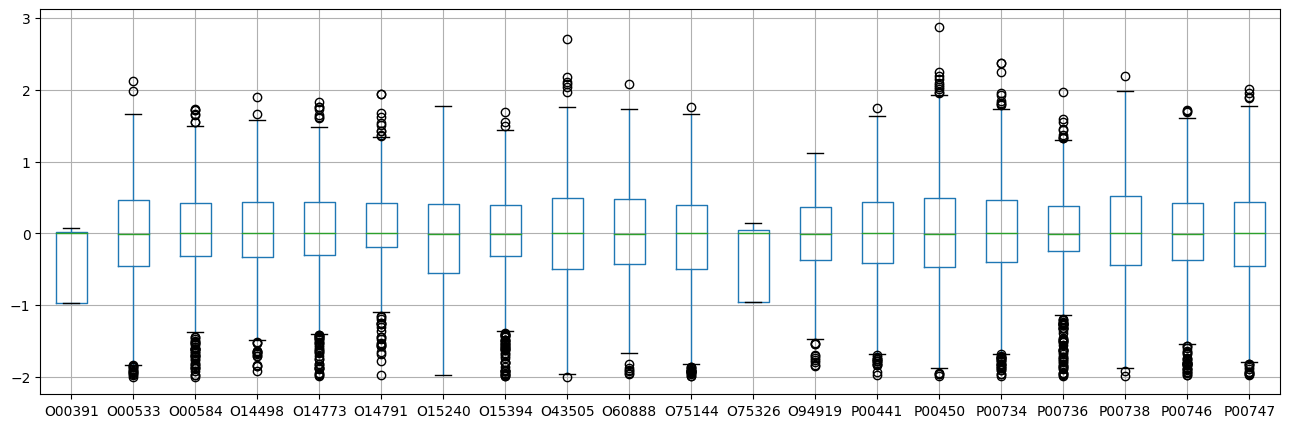

In [54]:
df1.iloc[:,:20].boxplot(figsize=(16,5))

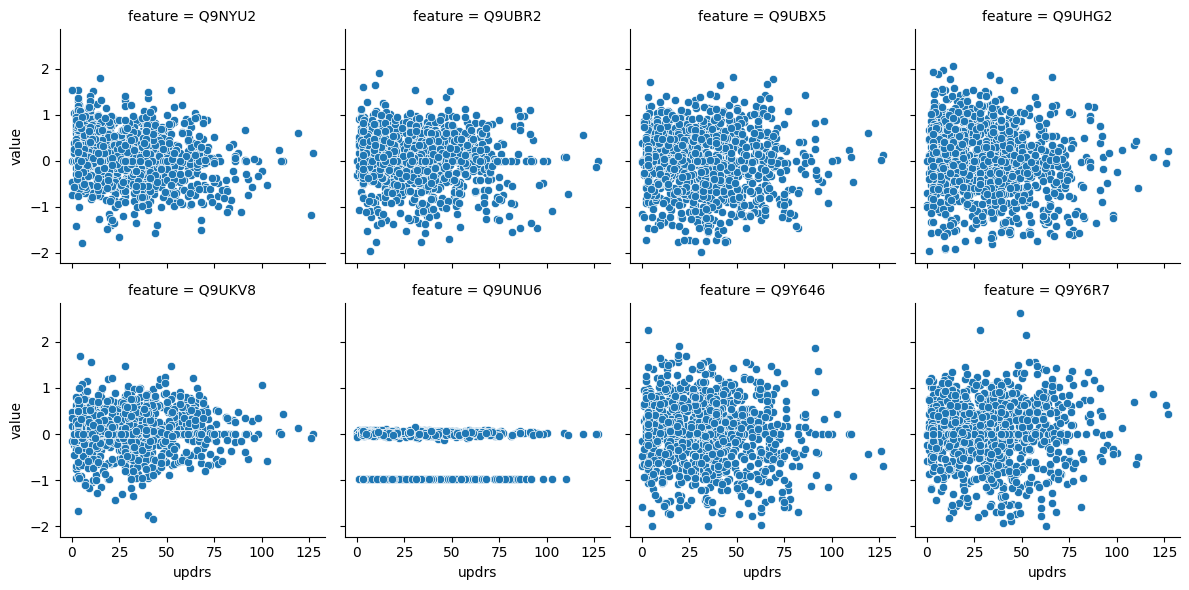

In [55]:
m = df1.iloc[:,-9:].melt(id_vars=['updrs'], var_name='feature')
g = sns.FacetGrid(m, col='feature', col_wrap=4)
g.map_dataframe(sns.scatterplot, x='updrs', y='value')

## **Second option NPX vs Time**

### Second dataframe generation

In [56]:
# Copy df_proteins_ datafram in df2_pre dataframe
df2_pre = df_proteins_.copy()
df2_pre.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,55_0,0.013127,0.670496,0.763220,0.980540,1.045347,0.723823,0.493669,0.411514,1.117953,...,0.461159,0.076783,-0.231475,0.911468,1.140102,1.095780,-14.428781,0.065964,0.540623,0.066043
1,1517_0,0.016781,-0.230696,0.533761,-20.642740,0.058720,0.099265,0.018511,-0.314723,-0.208763,...,0.250633,-0.334073,-30.470617,-0.225343,0.278439,-0.442750,-0.142632,0.071873,0.094211,-0.281903
2,1923_0,0.081074,0.942653,0.363814,-20.642740,-0.394453,-11.933514,0.981905,0.835193,1.014250,...,-1.617695,0.663979,0.250438,-0.023872,1.327897,1.436155,0.052761,0.050811,0.780066,0.366023
3,2660_0,-0.975931,0.293478,0.127174,0.311463,0.213493,-0.492851,0.164362,0.601191,0.265852,...,-0.117288,-0.036434,0.488983,-0.009597,-0.575823,0.538580,-0.150511,0.014832,0.714222,-0.005308
4,3636_0,0.009609,-0.955498,-1.587675,-0.997780,-1.581073,0.193502,-0.755321,-1.032201,-1.789479,...,-0.078344,-12.077402,-1.002169,-1.137671,-1.516837,-0.698239,-14.428781,-0.967985,-2.071915,-1.017786


In [57]:
# Take 'visit_time' from 'visit_id'
df2_pre['visit_time'] = df2_pre['visit_id'].apply(lambda x: x[(x.find('_')+1):])

# Drop 'visit_id' column
df2_outliers = df2_pre.drop(['visit_id'], axis=1)
df2_outliers.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,visit_time
0,0.013127,0.670496,0.763220,0.980540,1.045347,0.723823,0.493669,0.411514,1.117953,0.392114,...,0.076783,-0.231475,0.911468,1.140102,1.095780,-14.428781,0.065964,0.540623,0.066043,0
1,0.016781,-0.230696,0.533761,-20.642740,0.058720,0.099265,0.018511,-0.314723,-0.208763,-0.637695,...,-0.334073,-30.470617,-0.225343,0.278439,-0.442750,-0.142632,0.071873,0.094211,-0.281903,0
2,0.081074,0.942653,0.363814,-20.642740,-0.394453,-11.933514,0.981905,0.835193,1.014250,1.429801,...,0.663979,0.250438,-0.023872,1.327897,1.436155,0.052761,0.050811,0.780066,0.366023,0
3,-0.975931,0.293478,0.127174,0.311463,0.213493,-0.492851,0.164362,0.601191,0.265852,0.966835,...,-0.036434,0.488983,-0.009597,-0.575823,0.538580,-0.150511,0.014832,0.714222,-0.005308,0
4,0.009609,-0.955498,-1.587675,-0.997780,-1.581073,0.193502,-0.755321,-1.032201,-1.789479,-0.344913,...,-12.077402,-1.002169,-1.137671,-1.516837,-0.698239,-14.428781,-0.967985,-2.071915,-1.017786,0


### Detecting and treating Outliers

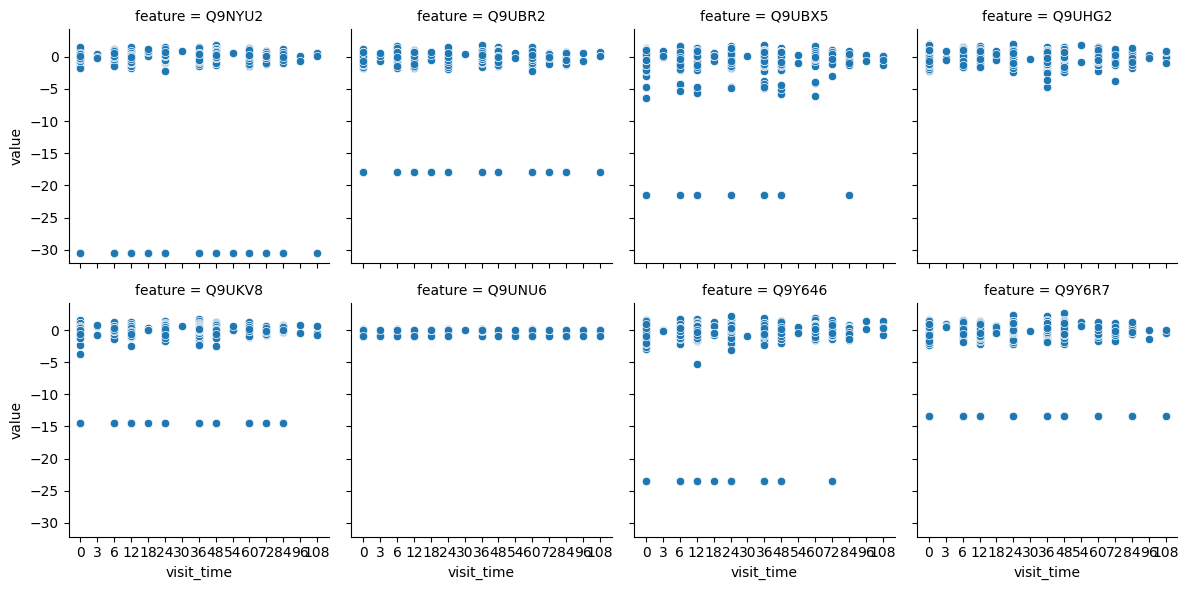

In [58]:
# Plot features (proteins) vs visit_time
m = df2_outliers.iloc[:,-9:].melt(id_vars=['visit_time'], var_name='feature')
g = sns.FacetGrid(m, col='feature', col_wrap=4)
g.map_dataframe(sns.scatterplot, x='visit_time', y='value')

<Axes: >

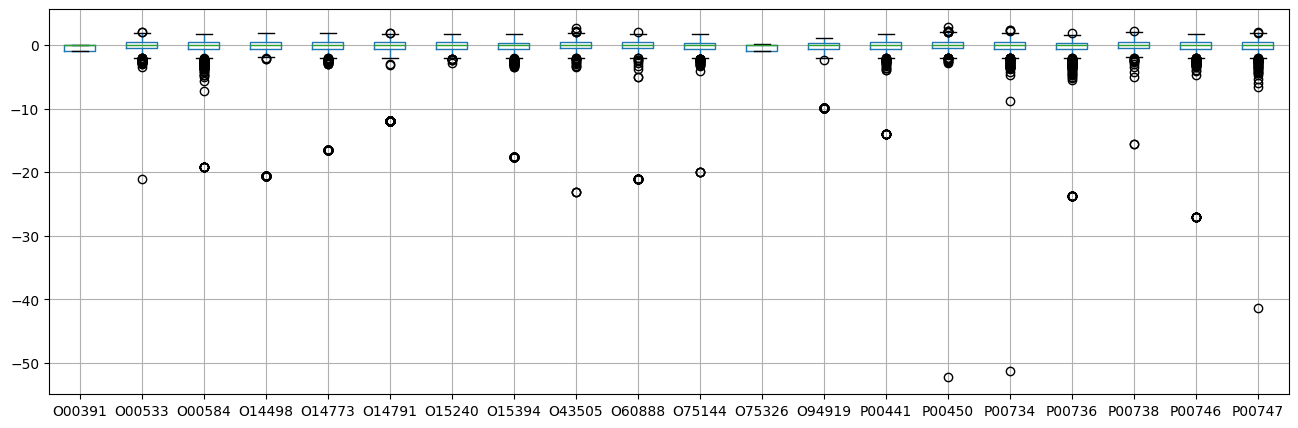

In [59]:
# Plot a boxplot of proteins
df2_outliers.iloc[:,:20].boxplot(figsize=(16,5))

In [60]:
# Impute outliers to the mean
df2_outliers['visit_time'] = df2_outliers['visit_time'].astype('Int64')
df2 = df2_outliers.mask(df2_outliers < -2, df2_outliers.median(), axis=1)
df2.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,visit_time
0,0.013127,0.670496,0.763220,0.980540,1.045347,0.723823,0.493669,0.411514,1.117953,0.392114,...,0.076783,-0.231475,0.911468,1.140102,1.095780,0.000000,0.065964,0.540623,0.066043,0
1,0.016781,-0.230696,0.533761,0.000000,0.058720,0.099265,0.018511,-0.314723,-0.208763,-0.637695,...,-0.334073,0.000000,-0.225343,0.278439,-0.442750,-0.142632,0.071873,0.094211,-0.281903,0
2,0.081074,0.942653,0.363814,0.000000,-0.394453,0.000000,0.981905,0.835193,1.014250,1.429801,...,0.663979,0.250438,-0.023872,1.327897,1.436155,0.052761,0.050811,0.780066,0.366023,0
3,-0.975931,0.293478,0.127174,0.311463,0.213493,-0.492851,0.164362,0.601191,0.265852,0.966835,...,-0.036434,0.488983,-0.009597,-0.575823,0.538580,-0.150511,0.014832,0.714222,-0.005308,0
4,0.009609,-0.955498,-1.587675,-0.997780,-1.581073,0.193502,-0.755321,-1.032201,-1.789479,-0.344913,...,0.000000,-1.002169,-1.137671,-1.516837,-0.698239,0.000000,-0.967985,0.000000,-1.017786,0


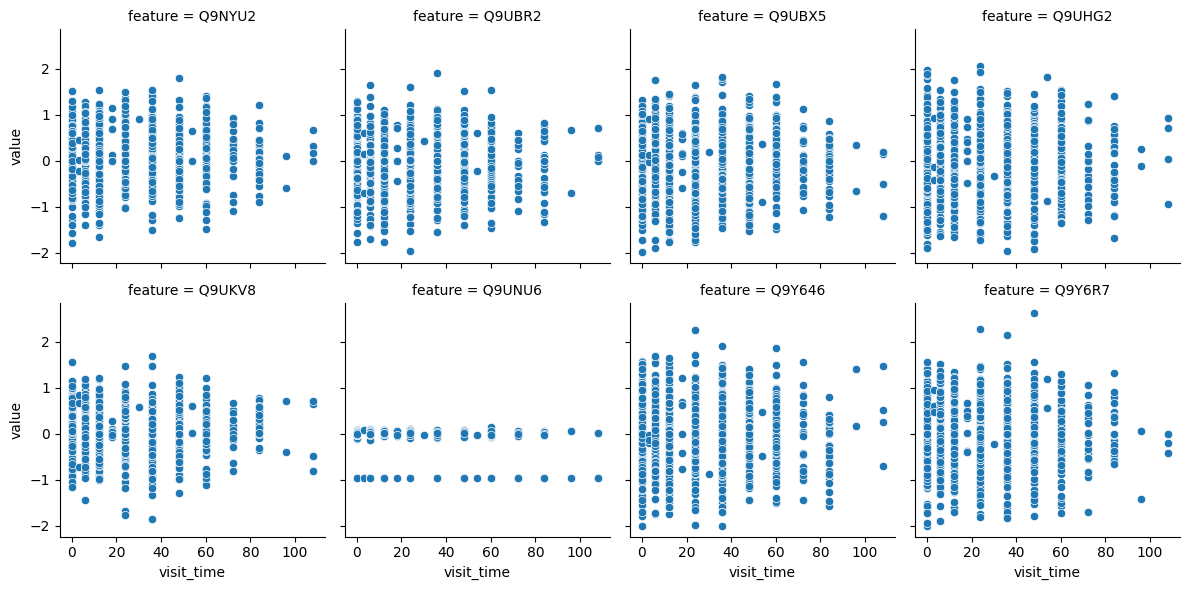

In [61]:
# Plot features (proteins) vs UPDRS
m = df2.iloc[:,-9:].melt(id_vars=['visit_time'], var_name='feature')
g = sns.FacetGrid(m, col='feature', col_wrap=4)
g.map_dataframe(sns.scatterplot, x='visit_time', y='value')

# **Machine Learning**

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, StackingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [64]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

In [65]:
from sklearn.metrics import r2_score

In [66]:
from sklearn.metrics import accuracy_score

## **First dataframe training**

### Regression models

In [67]:
X1 = df1.iloc[:,:-1]
y1 = df1['updrs']

In [68]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size=0.30, random_state=0)

In [69]:
# Regression models
mdl_knr = KNeighborsRegressor()
mdl_svr = SVR()
mdl_dtr = DecisionTreeRegressor()
mdl_rfr = RandomForestRegressor()
mdl_abr = AdaBoostRegressor()
mdl_br = BaggingRegressor()
mdl_gbr = GradientBoostingRegressor()
mdl_hgbr = HistGradientBoostingRegressor()
mdl_lr = LinearRegression()
mdl_mlpr = MLPRegressor()

In [70]:
list_mdl = [mdl_knr, mdl_svr, mdl_dtr, mdl_rfr, mdl_abr, mdl_br, mdl_gbr, mdl_hgbr, mdl_lr, mdl_mlpr]
names_mdl = ["KNR","SVR","Decision Tree","Random Forest","Ada Boost","Bagging","Gradient Boosting","Hist Gradient Boosting","Linear Regressor", "Multilayer Perceptron"]
y_mdl_pred = list()

In [71]:
print("{:>25} {:>10}".format(*["MODEL","SCORE"]))
for n, mdl in enumerate(list_mdl):
    mdl.fit(X1_train, y1_train)
    y1_predict = mdl.predict(X1_test)
    score = r2_score(y1_test, y1_predict)
    show_values = [names_mdl[n],  np.round(score,2)]
    print("{:>25} {:>10}".format(*show_values))

                    MODEL      SCORE
                      KNR       0.29
                      SVR       0.07
            Decision Tree      -0.79
            Random Forest       0.25
                Ada Boost       0.13
                  Bagging       0.15
        Gradient Boosting       0.21
   Hist Gradient Boosting       0.26
         Linear Regressor      -0.04
    Multilayer Perceptron       0.14


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## **Second dataframe training**

### Cassification models

In [72]:
X2 = df2.iloc[:,:-1]
y2 = df2['visit_time']

In [73]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size=0.30, random_state=0)

In [74]:
mdl_knc = KNeighborsClassifier()
mdl_svc = SVC()
mdl_dtc = DecisionTreeClassifier()
mdl_rfc = RandomForestClassifier()
mdl_abc = AdaBoostClassifier()
mdl_bc = BaggingClassifier()
mdl_gbc = GradientBoostingClassifier()
mdl_hgbc = HistGradientBoostingClassifier()
mdl_mlpc = MLPClassifier()

In [75]:
list_mdl = [mdl_knc, mdl_svc, mdl_dtc, mdl_rfc, mdl_abc, mdl_bc, mdl_gbc, mdl_hgbc, mdl_mlpc]
names_mdl = ["KNC","SVC","Decision Tree","Random Forest","Ada Boost","Bagging","Gradient Boosting","Hist Gradient Boosting","Multilayer Perceptron"]
y_mdl_pred = list()

In [76]:
print("{:>25} {:>10}".format(*["MODEL","SCORE"]))
for n, mdl in enumerate(list_mdl):
    mdl.fit(X2_train, y2_train)
    y2_predict = mdl.predict(X2_test)
    score = accuracy_score(y2_test, y2_predict)
    show_values = [names_mdl[n],  np.round(score,2)]
    print("{:>25} {:>10}".format(*show_values))

                    MODEL      SCORE
                      KNC       0.08
                      SVC       0.12
            Decision Tree       0.15
            Random Forest        0.1
                Ada Boost       0.13
                  Bagging        0.1
        Gradient Boosting        0.1
   Hist Gradient Boosting       0.07
    Multilayer Perceptron       0.06


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
